In [1]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
from keras.layers.core import Dense, Activation, Flatten, Dropout, Reshape
from keras.layers import Conv2D, LSTM, Embedding, Bidirectional, Input, merge, multiply, concatenate, add, GlobalAveragePooling1D, Layer, TimeDistributed, Conv1D, Lambda, Add
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.utils import to_categorical
from keras import regularizers
from keras.models import Model
from keras import backend as K
import tensorflow as tf

from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.initializers import *

Using TensorFlow backend.


In [2]:
with open('dataset/PELM/fixed_sequences_length_9/Group_Phos_Y_neg.fasta', 'r') as f:
    s_negatif_txt = f.readlines()

s_negatif = np.array([])
for i in range(1,len(s_negatif_txt),2):
    temp = s_negatif_txt[i]
    temp1 = temp[0:9]
    temp2 = list(temp1)
    s_negatif = np.append(s_negatif, temp2)

sequenceL = int(len(s_negatif)/9)
s_negatif_new = np.expand_dims(s_negatif, axis=0)
s_negatif_new = s_negatif_new.reshape(sequenceL,9)
labelneg = np.zeros((sequenceL,), dtype=int)
s_negatif_label = np.expand_dims(labelneg, axis=0)
s_negatif_label = s_negatif_label.reshape(sequenceL,1)
print(s_negatif_new.shape)
print(s_negatif_label.shape)


(226, 9)
(226, 1)


In [3]:
with open('dataset/PELM/fixed_sequences_length_9/Group_Phos_Y_pos.fasta', 'r') as f:
    s_positif_txt = f.readlines()

s_positif = np.array([])
for i in range(1,len(s_positif_txt),2):
    temp = s_positif_txt[i]
    temp1 = temp[0:9]
    temp2 = list(temp1)
    s_positif = np.append(s_positif, temp2)

sequenceL = int(len(s_positif)/9)
s_positif_new = np.expand_dims(s_positif, axis=0)
s_positif_new = s_positif_new.reshape(sequenceL,9)
labelpos = np.ones((sequenceL,), dtype=int)
s_positif_label = np.expand_dims(labelpos, axis=0)
s_positif_label = s_positif_label.reshape(sequenceL,1)
print(s_positif_new.shape)
print(s_positif_label.shape)


(267, 9)
(267, 1)


In [4]:
training_X = np.concatenate((s_positif_new, s_negatif_new), axis=0, out=None)
training_Y = np.concatenate((s_positif_label, s_negatif_label), axis=0, out=None)

training_Y_onehot = to_categorical(training_Y)

asam = ['A','R','N','D','C','Q','E','G','H','I','L','K','M','F','P','S','T','W','Y','V']
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(asam)
sequence_of_int = []
for i in range(len(training_X)):
    temp = tokenizer.texts_to_sequences(training_X[i])
    sequence_of_int = np.append(sequence_of_int, temp)

sequence_of_int = sequence_of_int-1
sequence_of_int_onehot = to_categorical(sequence_of_int)
sequence_of_int_onehot = np.expand_dims(sequence_of_int_onehot, axis=3)
sequence_of_int_onehot = sequence_of_int_onehot.reshape(len(training_X),9,20,1)
sequence_of_int = sequence_of_int.reshape(len(training_X),9)

print(sequence_of_int_onehot.shape)
train_X, valid_X, train_label, valid_label = train_test_split(sequence_of_int, training_Y_onehot, test_size=0.2, random_state=13)
print(train_X.shape)
print(valid_X[0])

(493, 9, 20, 1)
(394, 9)
[ 5.  1.  3. 10. 18. 15.  7. 10.  2.]


/home/adminsvr/.venv/phos/lib/python3.5/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


In [ ]:
#LSTM
epochs = 100

inp = Input(shape=(9,))
emb = Embedding(20, 8, input_length=9)(inp)


att = LSTM(9, activation = 'softmax')(emb)
att = Reshape(target_shape=(9,1))(att)
att = concatenate([att,att,att,att,att,att,att,att], axis=2)
emb = multiply([emb, att])

i = LSTM(20, return_sequences=True)(emb)
# i = LSTM(20, return_sequences=True)(i)
# i = LSTM(20, return_sequences=True)(i)
# i = LSTM(20, return_sequences=True)(i)
# i = LSTM(20, return_sequences=True)(i)
i = LSTM(20, return_sequences=False)(i)

out = Dense(2, activation='softmax')(i)

model = Model(inputs=inp, outputs=out)
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

model.summary()


In [ ]:
# Bidirectional LSTM
epochs = 100

inp = Input(shape=(9,))
emb = Embedding(20, 8, input_length=9)(inp)


att = Bidirectional(LSTM(9, activation = 'softmax'), merge_mode='ave', weights=None)(emb)
att = Reshape(target_shape=(9,1))(att)
att = concatenate([att,att,att,att,att,att,att,att], axis=2)
emb = multiply([emb, att])

i = Bidirectional(LSTM(20), merge_mode='concat', weights=None)(emb)

out = Dense(2, activation='softmax')(i)

model = Model(inputs=inp, outputs=out)
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

model.summary()

# model.add(Bidirectional(LSTM(128, kernel_regularizer=regularizers.l2(0.1), recurrent_regularizer=regularizers.l2(0.1), 
#                              bias_regularizer=regularizers.l2(0.1)), merge_mode='concat', weights=None))

In [ ]:
#Dense
epochs = 300

inp = Input(shape=(9,))

emb = Embedding(20, 8, input_length=9)(inp)
# pos_emb = Embedding(20, 8, trainable=False, weights=[GetPosEncodingMatrix(20, 8)], input_length=9)(inp)
# emb = add([emb, pos_emb])

att = Dense(1, activation = 'softmax')(emb)
att = concatenate([att,att,att,att,att,att,att,att], axis=2)
emb = multiply([emb, att])

i = Dense(100)(emb)
i = Dense(100)(i)
i = Dense(100)(i)
i = Dense(100)(i)
i = Dense(100)(i)
i = Dense(100)(i)
i = Flatten()(i)

out = Dense(2, activation='softmax')(i)

model = Model(inputs=inp, outputs=out)
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

model.summary()

In [5]:
# library Transformer
def GetPosEncodingMatrix(max_len, d_emb):
    pos_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)] 
        if pos != 0 else np.zeros(d_emb) 
            for pos in range(max_len)
            ])
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2]) # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2]) # dim 2i+1
    return pos_enc

class LayerNormalization(Layer):
	def __init__(self, eps=1e-6, **kwargs):
		self.eps = eps
		super(LayerNormalization, self).__init__(**kwargs)
	def build(self, input_shape):
		self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
									 initializer=Ones(), trainable=True)
		self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
									initializer=Zeros(), trainable=True)
		super(LayerNormalization, self).build(input_shape)
	def call(self, x):
		mean = K.mean(x, axis=-1, keepdims=True)
		std = K.std(x, axis=-1, keepdims=True)
		return self.gamma * (x - mean) / (std + self.eps) + self.beta
	def compute_output_shape(self, input_shape):
		return input_shape
    
class ScaledDotProductAttention():
	def __init__(self, d_model, attn_dropout=0.1):
		self.temper = np.sqrt(d_model)
		self.dropout = Dropout(attn_dropout)
	def __call__(self, q, k, v, mask):
		attn = Lambda(lambda x:K.batch_dot(x[0],x[1],axes=[2,2])/self.temper)([q, k])
		if mask is not None:
			mmask = Lambda(lambda x:(-1e+10)*(1-x))(mask)
			attn = Add()([attn, mmask])
		attn = Activation('softmax')(attn)
		attn = self.dropout(attn)
		output = Lambda(lambda x:K.batch_dot(x[0], x[1]))([attn, v])
		return output, attn
    
class MultiHeadAttention():
	# mode 0 - big martixes, faster; mode 1 - more clear implementation
	def __init__(self, n_head, d_model, d_k, d_v, dropout, mode=0, use_norm=True):
		self.mode = mode
		self.n_head = n_head
		self.d_k = d_k
		self.d_v = d_v
		self.dropout = dropout
		if mode == 0:
			self.qs_layer = Dense(n_head*d_k, use_bias=False)
			self.ks_layer = Dense(n_head*d_k, use_bias=False)
			self.vs_layer = Dense(n_head*d_v, use_bias=False)
		elif mode == 1:
			self.qs_layers = []
			self.ks_layers = []
			self.vs_layers = []
			for _ in range(n_head):
				self.qs_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
				self.ks_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
				self.vs_layers.append(TimeDistributed(Dense(d_v, use_bias=False)))
		self.attention = ScaledDotProductAttention(d_model)
		self.layer_norm = LayerNormalization() if use_norm else None
		self.w_o = TimeDistributed(Dense(d_model))

	def __call__(self, q, k, v, mask=None):
		d_k, d_v = self.d_k, self.d_v
		n_head = self.n_head

		if self.mode == 0:
			qs = self.qs_layer(q)  # [batch_size, len_q, n_head*d_k]
			ks = self.ks_layer(k)
			vs = self.vs_layer(v)

			def reshape1(x):
				s = tf.shape(x)   # [batch_size, len_q, n_head * d_k]
				x = tf.reshape(x, [s[0], s[1], n_head, s[2]//n_head])
				x = tf.transpose(x, [2, 0, 1, 3])  
				x = tf.reshape(x, [-1, s[1], s[2]//n_head])  # [n_head * batch_size, len_q, d_k]
				return x
			qs = Lambda(reshape1)(qs)
			ks = Lambda(reshape1)(ks)
			vs = Lambda(reshape1)(vs)

			if mask is not None:
				mask = Lambda(lambda x:K.repeat_elements(x, n_head, 0))(mask)
			head, attn = self.attention(qs, ks, vs, mask=mask)  
				
			def reshape2(x):
				s = tf.shape(x)   # [n_head * batch_size, len_v, d_v]
				x = tf.reshape(x, [n_head, -1, s[1], s[2]]) 
				x = tf.transpose(x, [1, 2, 0, 3])
				x = tf.reshape(x, [-1, s[1], n_head*d_v])  # [batch_size, len_v, n_head * d_v]
				return x
			head = Lambda(reshape2)(head)
		elif self.mode == 1:
			heads = []; attns = []
			for i in range(n_head):
				qs = self.qs_layers[i](q)   
				ks = self.ks_layers[i](k) 
				vs = self.vs_layers[i](v) 
				head, attn = self.attention(qs, ks, vs, mask)
				heads.append(head); attns.append(attn)
			head = Concatenate()(heads) if n_head > 1 else heads[0]
			attn = Concatenate()(attns) if n_head > 1 else attns[0]

		outputs = self.w_o(head)
		outputs = Dropout(self.dropout)(outputs)
		if not self.layer_norm: return outputs, attn
		outputs = Add()([outputs, q])
		return self.layer_norm(outputs), attn

class PositionwiseFeedForward():
    def __init__(self, d_hid, d_inner_hid, dropout=0.1):
        self.w_1 = Conv1D(d_inner_hid, 1, activation='relu')
        self.w_2 = Conv1D(d_hid, 1)
        self.layer_norm = LayerNormalization()
        self.dropout = Dropout(dropout)
    def __call__(self, x):
        output = self.w_1(x) 
        output = self.w_2(output)
        output = self.dropout(output)
        output = Add()([output, x])
        output = self.layer_norm(output)
        return output
    
class EncoderLayer():
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        self.self_att_layer = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn_layer  = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)
    def __call__(self, enc_input, mask=None):
        output, slf_attn = self.self_att_layer(enc_input, enc_input, enc_input, mask=mask)
        output = self.pos_ffn_layer(output)
        return output, slf_attn

In [10]:
#Transformer
epochs = 300
d_model = 16
d_emb = d_model
d_inner_hid = 2*d_model
n_head = 4
d_k = d_model//4
d_v = d_model//4
dropout = 0.5

inp = Input(shape=(9,))

emb = Embedding(20, d_emb, input_length=9)(inp)

out, slf_attn = EncoderLayer(d_emb, d_inner_hid, n_head, d_k, d_v, dropout)(emb)
out, slf_attn = EncoderLayer(d_emb, d_inner_hid, n_head, d_k, d_v, dropout)(out)
out, slf_attn = EncoderLayer(d_emb, d_inner_hid, n_head, d_k, d_v, dropout)(out)
out, slf_attn = EncoderLayer(d_emb, d_inner_hid, n_head, d_k, d_v, dropout)(out)
out, slf_attn = EncoderLayer(d_emb, d_inner_hid, n_head, d_k, d_v, dropout)(out)
out, slf_attn = EncoderLayer(d_emb, d_inner_hid, n_head, d_k, d_v, dropout)(out)
out = GlobalAveragePooling1D()(out)

out = Dense(2, activation='softmax')(out)

model = Model(inputs=inp, outputs=out)
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

# model.summary()

In [11]:
model_train = model.fit(train_X, train_label, epochs=epochs, batch_size=32, validation_data=(valid_X, valid_label))

Train on 394 samples, validate on 99 samples
Epoch 1/300
394/394 [==============================] - 8s 21ms/step - loss: 0.7252 - acc: 0.5660 - val_loss: 0.7823 - val_acc: 0.5152
Epoch 2/300
394/394 [==============================] - 1s 2ms/step - loss: 0.7254 - acc: 0.5254 - val_loss: 0.6471 - val_acc: 0.6263
Epoch 3/300
394/394 [==============================] - 1s 2ms/step - loss: 0.6862 - acc: 0.5736 - val_loss: 0.6269 - val_acc: 0.6263
Epoch 4/300
394/394 [==============================] - 1s 2ms/step - loss: 0.6605 - acc: 0.5635 - val_loss: 0.5133 - val_acc: 0.7677
Epoch 5/300
394/394 [==============================] - 1s 2ms/step - loss: 0.6143 - acc: 0.6853 - val_loss: 0.6158 - val_acc: 0.7576
Epoch 6/300
394/394 [==============================] - 1s 2ms/step - loss: 0.6074 - acc: 0.6878 - val_loss: 0.5848 - val_acc: 0.7677
Epoch 7/300
394/394 [==============================] - 1s 2ms/step - loss: 0.5671 - acc: 0.7107 - val_loss: 0.5212 - val_acc: 0.8081
Epoch 8/300
394/394 [==

Epoch 62/300
394/394 [==============================] - 1s 2ms/step - loss: 0.4816 - acc: 0.7792 - val_loss: 0.5853 - val_acc: 0.7374
Epoch 63/300
394/394 [==============================] - 1s 2ms/step - loss: 0.4913 - acc: 0.7690 - val_loss: 0.5301 - val_acc: 0.7576
Epoch 64/300
394/394 [==============================] - 1s 2ms/step - loss: 0.4682 - acc: 0.7665 - val_loss: 0.5333 - val_acc: 0.7576
Epoch 65/300
394/394 [==============================] - 1s 2ms/step - loss: 0.4777 - acc: 0.8046 - val_loss: 0.5499 - val_acc: 0.7778
Epoch 66/300
394/394 [==============================] - 1s 2ms/step - loss: 0.4677 - acc: 0.7792 - val_loss: 0.5683 - val_acc: 0.7677
Epoch 67/300
394/394 [==============================] - 1s 2ms/step - loss: 0.4433 - acc: 0.7843 - val_loss: 0.5916 - val_acc: 0.7677
Epoch 68/300
394/394 [==============================] - 1s 2ms/step - loss: 0.4775 - acc: 0.7563 - val_loss: 0.5478 - val_acc: 0.7677
Epoch 69/300
394/394 [==============================] - 1s 2ms

Epoch 123/300
394/394 [==============================] - 1s 1ms/step - loss: 0.4473 - acc: 0.7640 - val_loss: 0.6972 - val_acc: 0.7273
Epoch 124/300
394/394 [==============================] - 1s 2ms/step - loss: 0.4282 - acc: 0.7944 - val_loss: 0.6288 - val_acc: 0.7778
Epoch 125/300
394/394 [==============================] - 1s 2ms/step - loss: 0.4311 - acc: 0.7817 - val_loss: 0.7368 - val_acc: 0.7172
Epoch 126/300
394/394 [==============================] - 1s 1ms/step - loss: 0.4159 - acc: 0.8020 - val_loss: 0.6781 - val_acc: 0.7475
Epoch 127/300
394/394 [==============================] - 1s 1ms/step - loss: 0.4128 - acc: 0.8020 - val_loss: 0.6928 - val_acc: 0.7374
Epoch 128/300
394/394 [==============================] - 1s 2ms/step - loss: 0.4223 - acc: 0.7995 - val_loss: 0.6739 - val_acc: 0.7172
Epoch 129/300
394/394 [==============================] - 1s 2ms/step - loss: 0.4305 - acc: 0.8046 - val_loss: 0.6711 - val_acc: 0.7576
Epoch 130/300
394/394 [==============================] 

KeyboardInterrupt: 

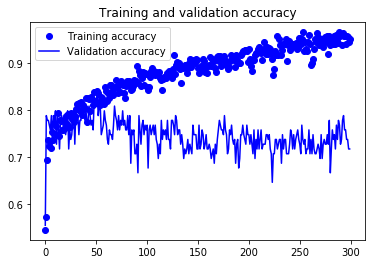

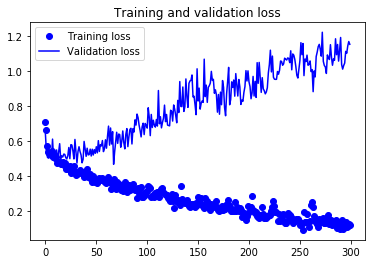

In [9]:
# Plot the training accuracy
accuracy = model_train.history['acc']
val_accuracy = model_train.history['val_acc']
loss = model_train.history['loss']
val_loss = model_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()